In [38]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
plt.style.use("ggplot")

In [2]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [3]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10,
    "yerr": 1e-4
}

In [5]:
traces = {
    "exoplanet+NUTS": az.InferenceData.from_netcdf(datadir("exoplanet+NUTS_trace.nc")),
    "exoplanet+MH": az.InferenceData.from_netcdf(datadir("exoplanet+MH_trace.nc")),
    "batman+MH": az.InferenceData.from_netcdf(datadir("batman+MH_trace.nc"))
}

In [7]:
trace = traces["exoplanet+NUTS"]

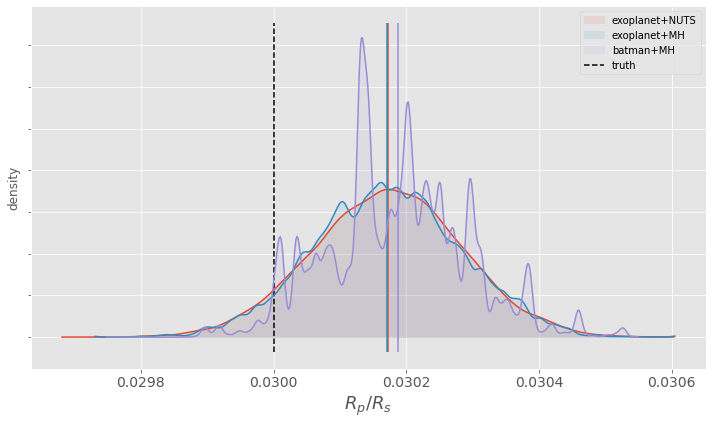

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, (name, trace) in enumerate(traces.items()):
    az.plot_kde(trace["posterior"]["r"], fill_kwargs={"alpha": 0.1}, label=name, plot_kwargs={"color": f"C{i}"}, ax=ax)

# rsum = np.mean([trace["posterior"]["r"].sum() for trace in traces.values()])
# ax.fill_between(np.linspace(0.01, 0.1, 100), rsum/(0.1 - 0.01), 0, color="r", alpha=0.1, label="prior")
ylims = ax.get_ylim()
ax.vlines(ground_truth["r"], *ylims, color="k", ls="--", label="truth", zorder=1)
for i, trace in enumerate(traces.values()):
    ax.vlines(np.median(trace["posterior"]["r"]), *ylims, color=f"C{i}")

ax.legend()
ax.set_xlabel("$R_p/R_s$", fontsize=18)
ax.set_ylabel("density")
# ax.set_xlim(0.029634691246069225, 0.0306508438078696)
ax.set_yticklabels([])
plt.tight_layout()

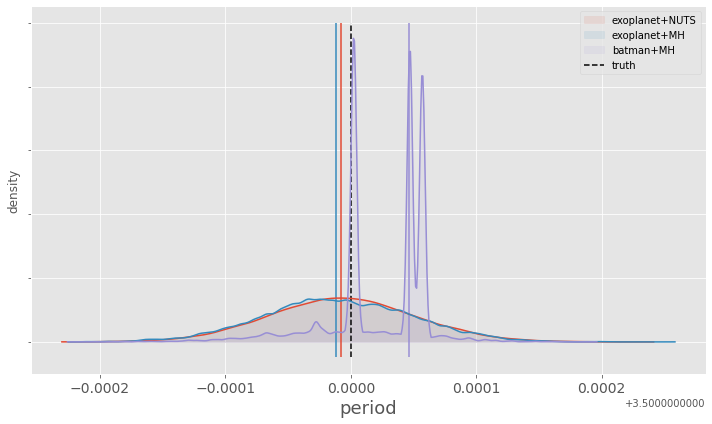

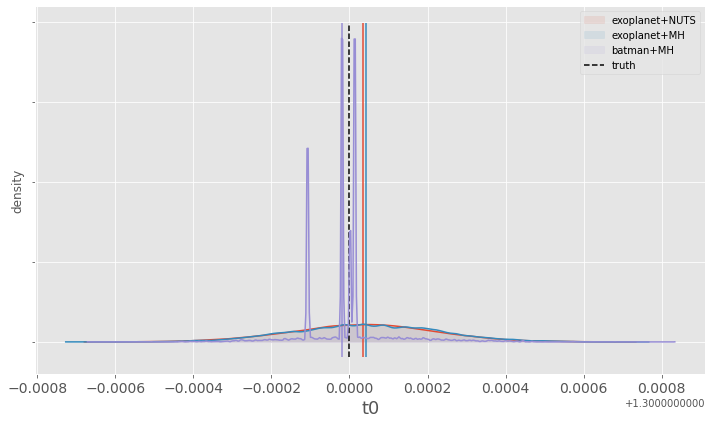

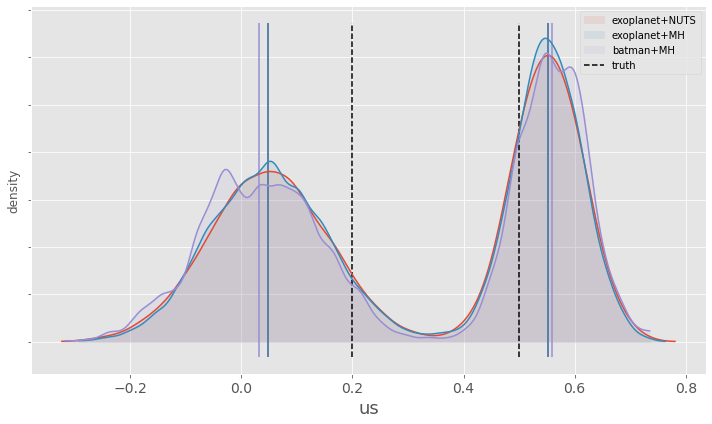

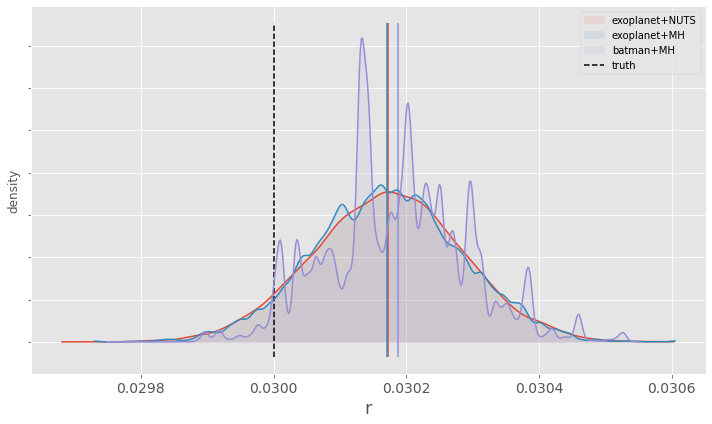

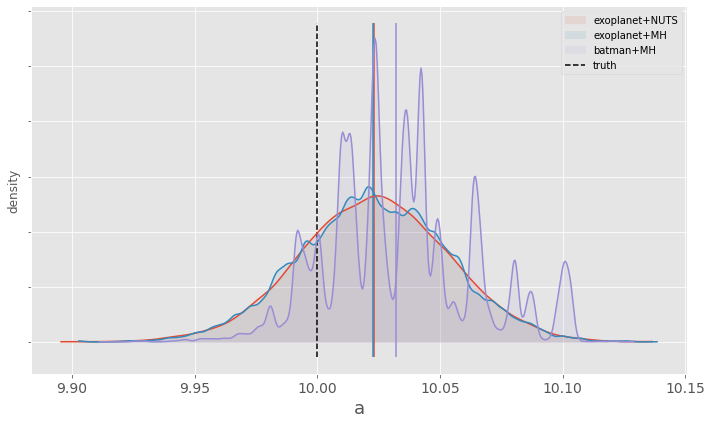

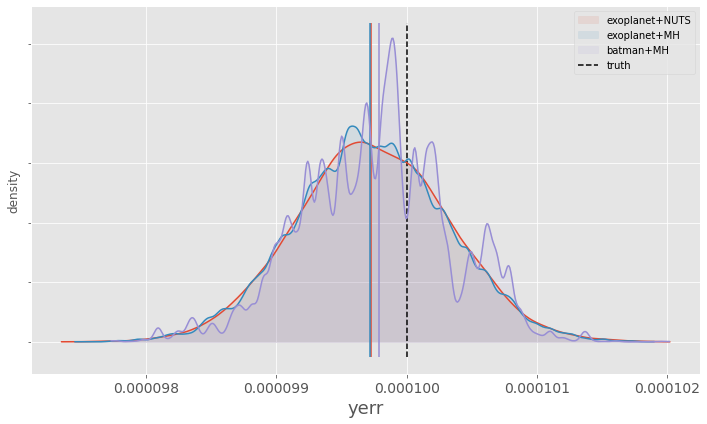

In [82]:
for param in ground_truth.keys():
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (name, trace) in enumerate(traces.items()):
        az.plot_kde(trace["posterior"][param], fill_kwargs={"alpha": 0.1}, label=name, plot_kwargs={"color": f"C{i}"}, ax=ax)

    # rsum = np.mean([trace["posterior"][param].sum() for trace in traces.values()])
    # ax.fill_between(np.linspace(0.01, 0.1, 100), rsum/(0.1 - 0.01), 0, color="r", alpha=0.1, label="prior")
    ylims = ax.get_ylim()
    ax.vlines(ground_truth[param], *ylims, color="k", ls="--", label="truth", zorder=1)
    for i, trace in enumerate(traces.values()):
        if param == "us":
            ax.vlines(np.median(trace["posterior"][param], axis=(0, 1)), *ylims, color=f"C{i}")
        else:
            ax.vlines(np.median(trace["posterior"][param]), *ylims, color=f"C{i}")

    ax.legend()
    ax.set_xlabel(param, fontsize=18)
    ax.set_ylabel("density")
    # ax.set_xlim(0.029634691246069225, 0.0306508438078696)
    ax.set_yticklabels([])
    plt.tight_layout()

In [84]:
with np.load(datadir("generated_data_100ppm.npz")) as data:
    t = data["t"]
    flux = data["flux"]
with np.load(datadir("generated_data.npz")) as data:
    trueflux = data["flux"]

In [97]:
preds = [np.quantile(trace["posterior"]["y"], [0.25, 0.50, 0.75], axis=(0, 1)) for trace in traces.values()]

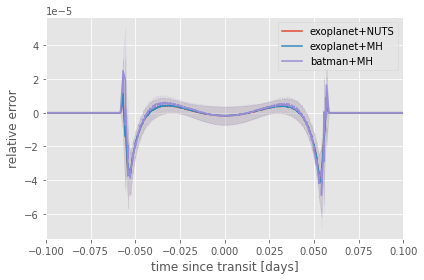

In [106]:
# Plot the folded data
x_fold = (t - ground_truth["t0"] + 0.5 * ground_truth["period"]) % ground_truth["period"] - 0.5 * ground_truth["period"]
maxphase = 0.1
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < maxphase]
# Plot the folded model residuals
for i, (name, pred) in enumerate(zip(traces, preds)):
    lq, md, hq = pred
    plt.plot(x_fold[inds], md[inds]/ trueflux[inds] - 1, color=f"C{i}", label=name)
    plt.fill_between(x_fold[inds], lq[inds]/ trueflux[inds] - 1, hq[inds]/ trueflux[inds] - 1, color=f"C{i}", alpha=0.1)

plt.legend()
plt.xlim(-maxphase, maxphase)
plt.xlabel("time since transit [days]")
plt.ylabel("relative error")
plt.tight_layout()